### Mixture Density Network

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch as th
import torch.nn as nn
import torch.nn.functional as F
from util import (
    get_torch_size_string,
    print_model_parameters,
    th2np,
)
from mdn import (
    MixtureDensityNetwork,
    gmm_forward,
    eval_mdn_1d,
)
from dataset import get_mdn_data
np.set_printoptions(precision=3)
th.set_printoptions(precision=3)
plt.rc('xtick',labelsize=8)
plt.rc('ytick',labelsize=8)
%matplotlib inline
%config InlineBackend.figure_format='retina'
print ("PyTorch version:[%s]."%(th.__version__))

PyTorch version:[2.0.1].


### Dataset

x_train_np:(5000, 1), y_train_np:(5000, 2)


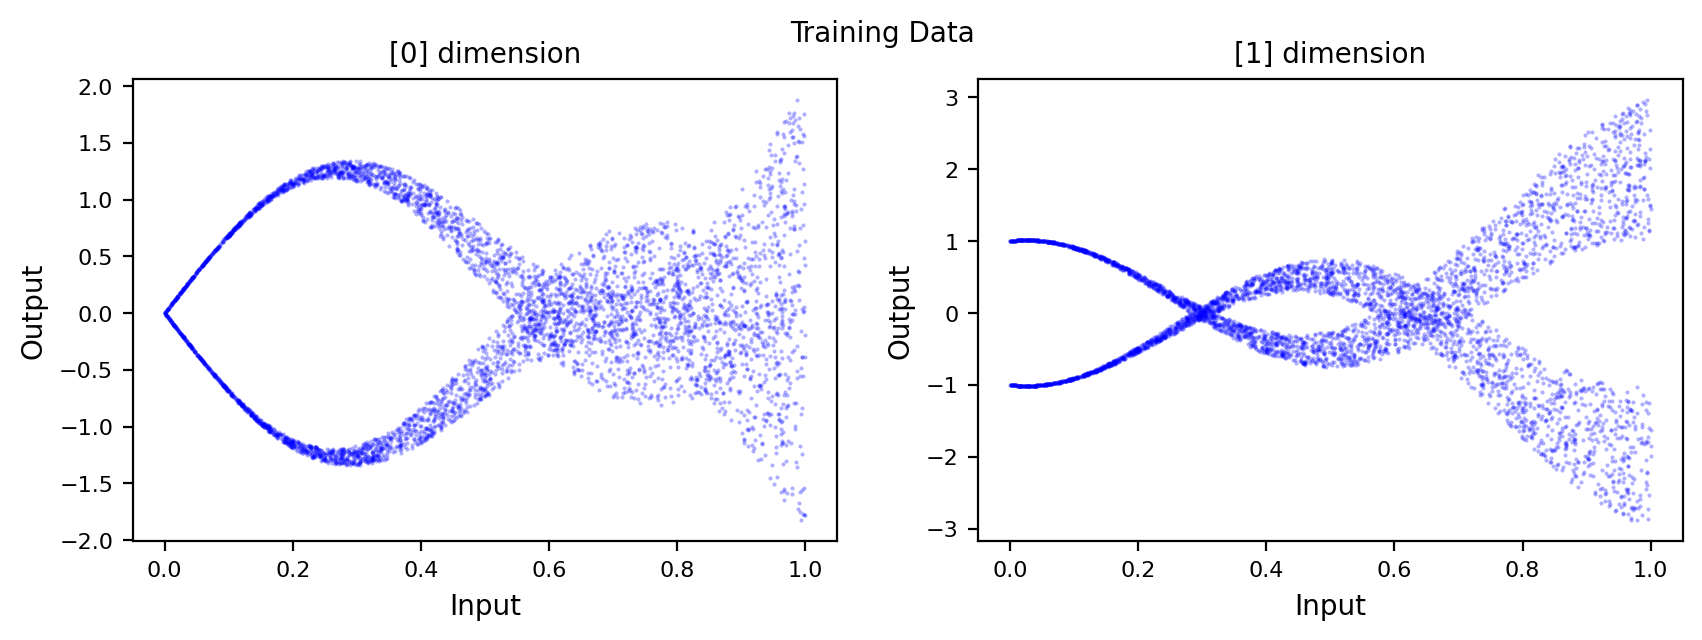

Done.


In [2]:
# Training data
n_train = 5000
x_train_np,y_train_np = get_mdn_data(
    n_train=n_train,x_min=0.0,x_max=1.0,y_min=0.0,y_max=1.0,freq=1,noise_rate=1.0,
    FLIP_AUGMENT=True)
print ("x_train_np:%s, y_train_np:%s"%(x_train_np.shape,y_train_np.shape))

# Plot
fig = plt.figure(figsize=(10,3))
for d_idx in range(y_train_np.shape[1]):
    plt.subplot(1,y_train_np.shape[1],d_idx+1)
    plt.plot(x_train_np,y_train_np[:,d_idx],'.',markersize=1,color=(0,0,1,0.3))
    plt.title('[%d] dimension'%(d_idx),fontsize=10)
    plt.xlabel('Input',fontsize=10); plt.ylabel('Output',fontsize=10)
fig.suptitle('Training Data',fontsize=10)
plt.show()
print ("Done.")

### MDN

In [3]:
device = 'mps'
print ("device:[%s]"%(device))

device:[mps]


In [4]:
mdn = MixtureDensityNetwork(
    name       = 'mdn',
    x_dim      = 1,
    y_dim      = 2,
    k          = 10,
    h_dim_list = [64,64],
    actv       = nn.SiLU(),
    sig_max    = 1.0,
    mu_min     = -3.0,
    mu_max     = +3.0,
    p_drop     = 0.0,
    use_bn     = False,
).to(device)
mdn.init_param()
optm = th.optim.Adam(mdn.parameters(),lr=1e-3,eps=1e-4,weight_decay=1e-4)
schd = th.optim.lr_scheduler.ExponentialLR(optimizer=optm,gamma=0.9999)

### Train

In [5]:
max_iter,batch_size,print_every,plot_every = 2e4,64,1000,5000
print ("max_iter:[%d] batch_size:[%d] print_every:[%d] plot_every:[%d]"%
      (max_iter,batch_size,print_every,plot_every))

max_iter:[20000] batch_size:[64] print_every:[1000] plot_every:[5000]


Start training
[   0/20000] loss:[4.256]


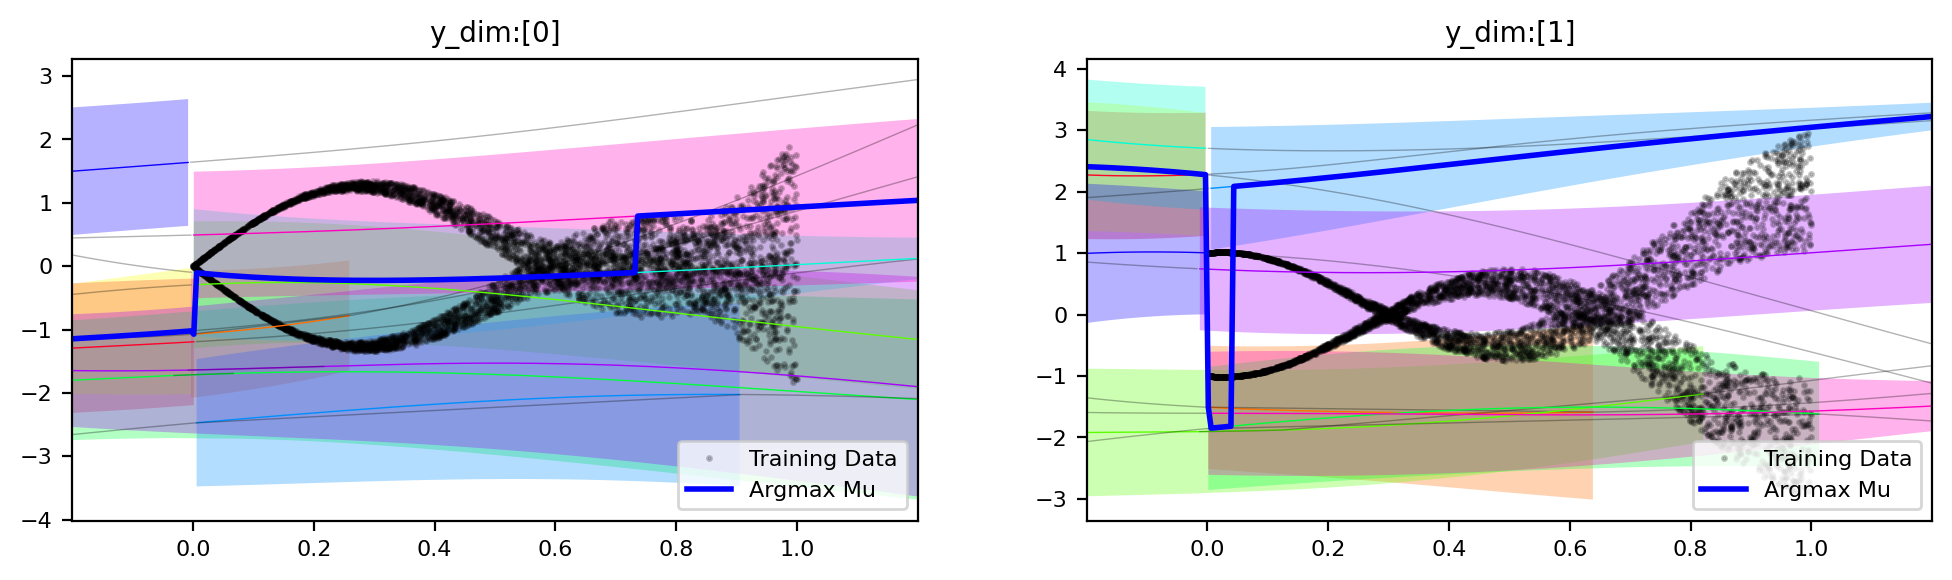

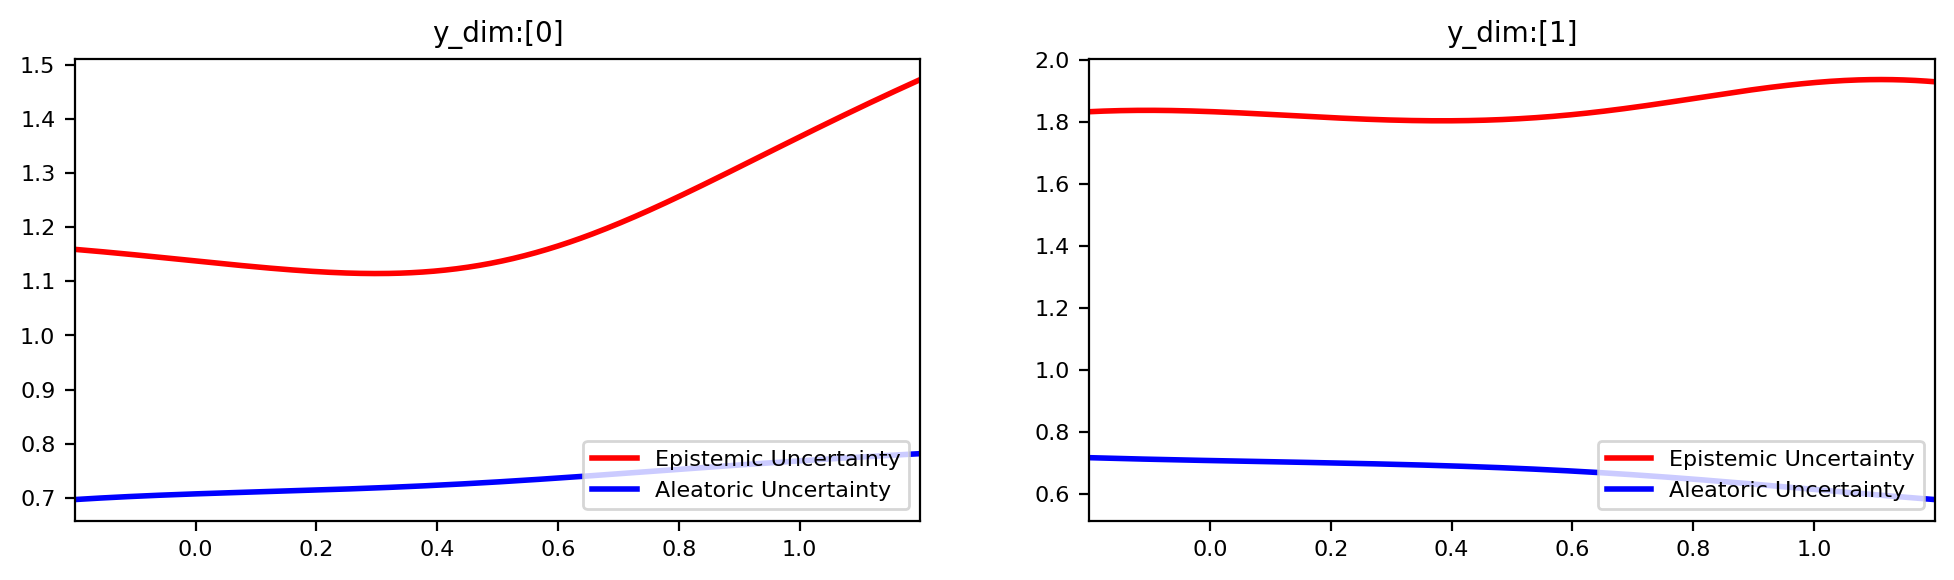

[1000/20000] loss:[-0.316]
[2000/20000] loss:[-0.222]
[3000/20000] loss:[-0.018]
[4000/20000] loss:[-0.451]
[5000/20000] loss:[-0.837]


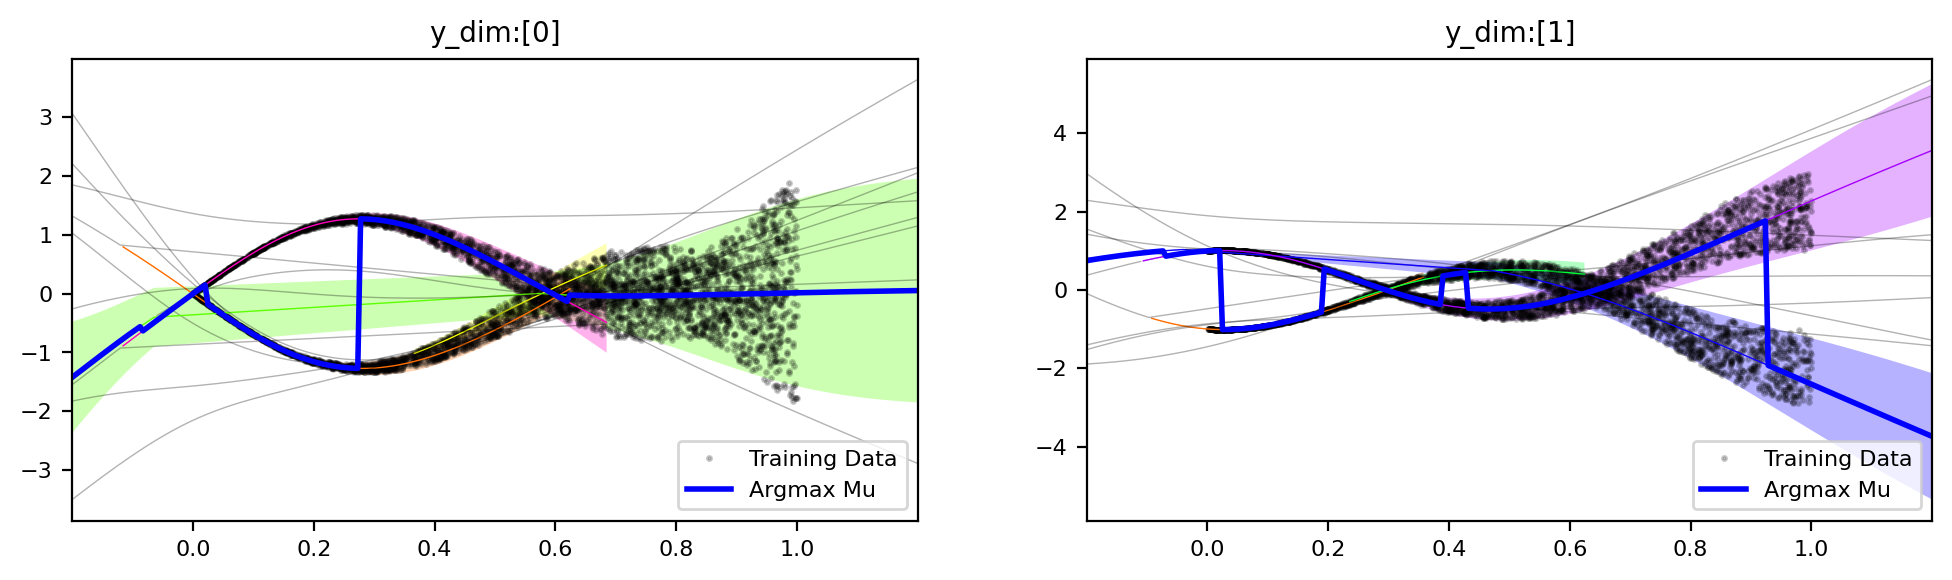

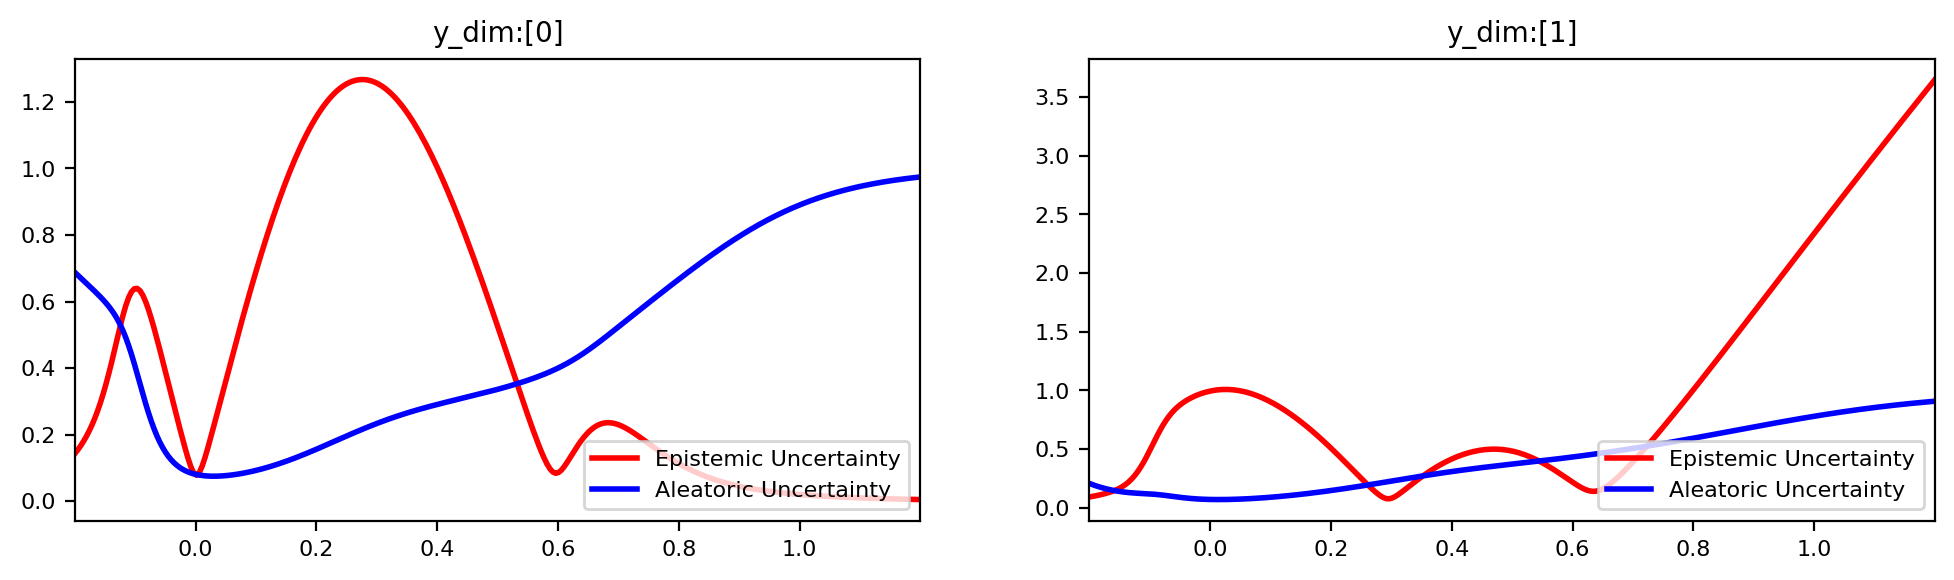

[6000/20000] loss:[-0.855]
[7000/20000] loss:[-0.978]
[8000/20000] loss:[-0.374]
[9000/20000] loss:[-0.261]
[10000/20000] loss:[-0.330]


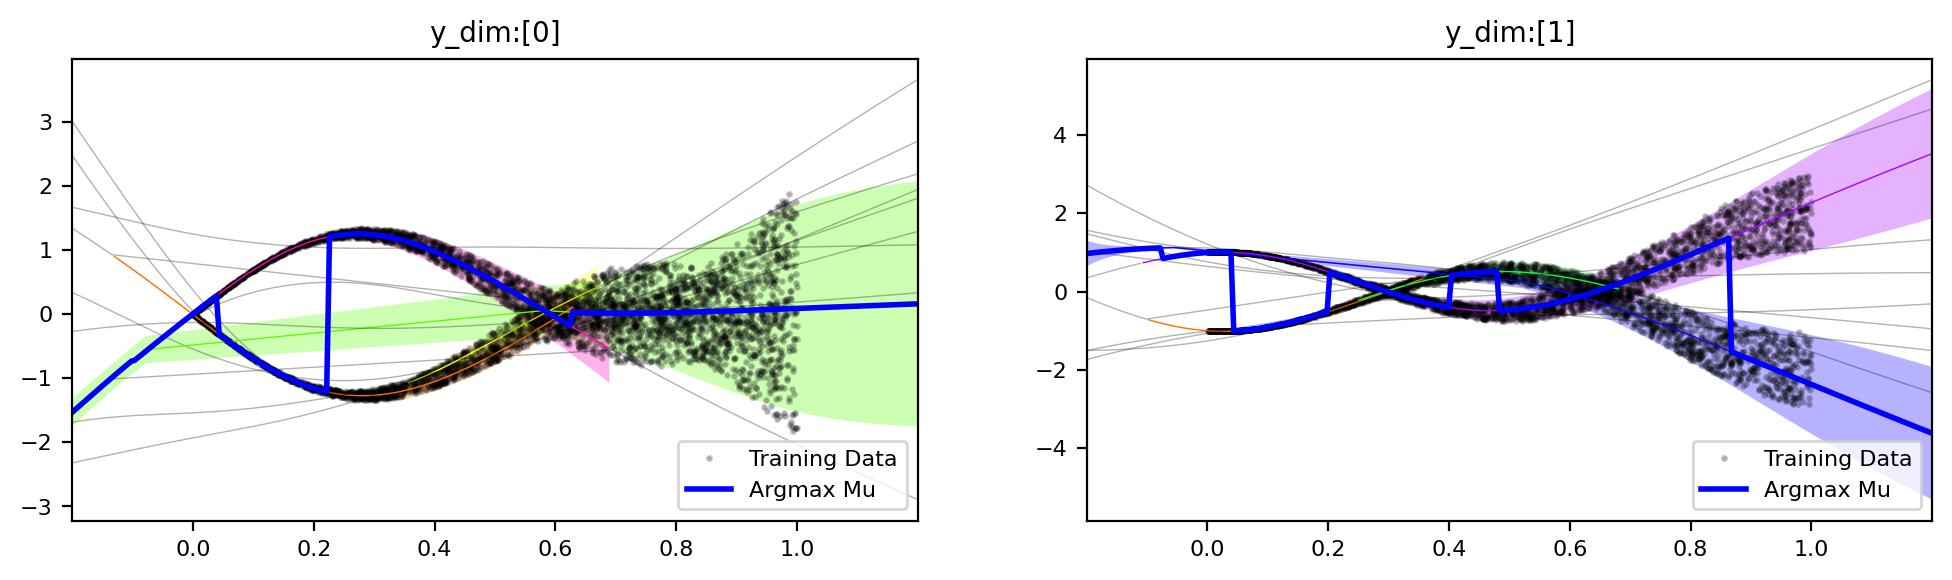

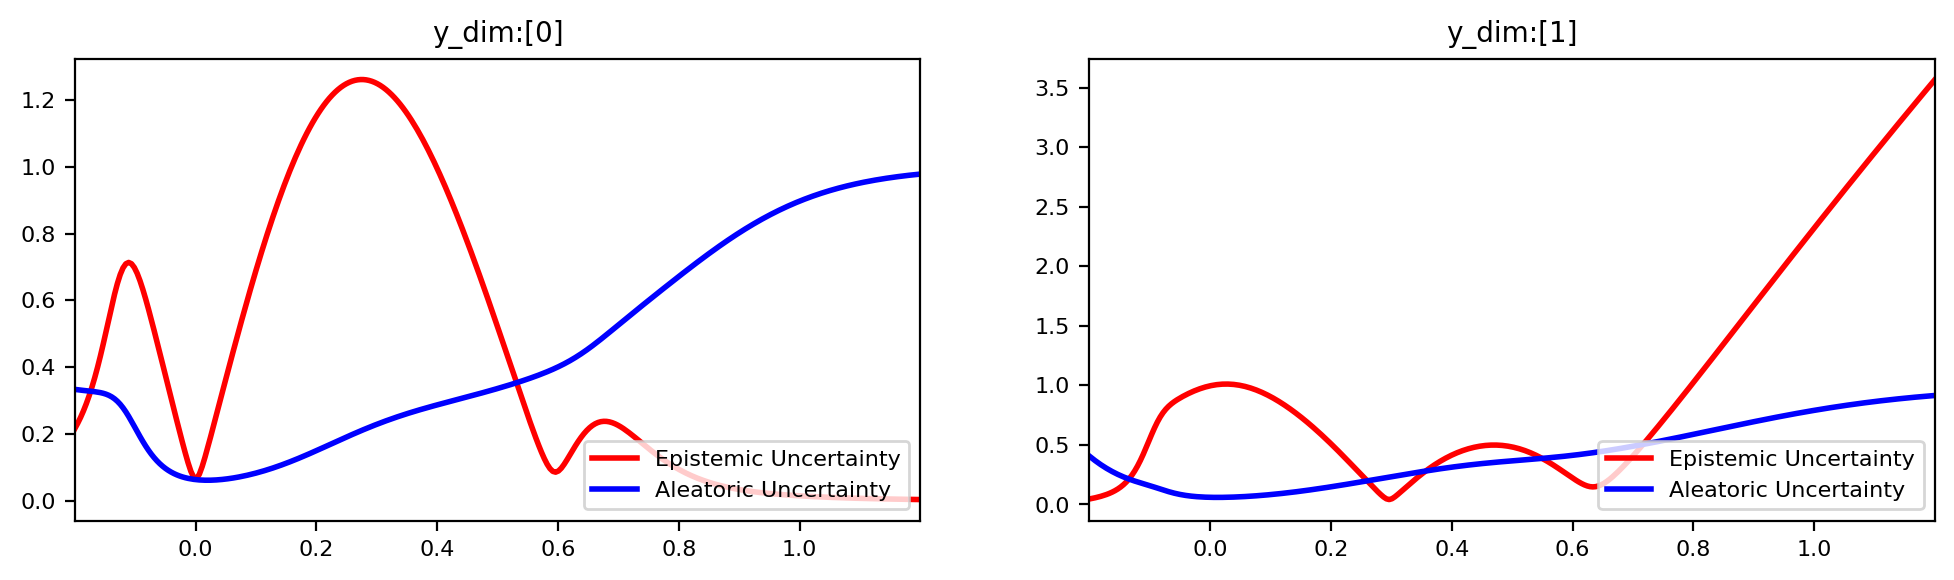

[11000/20000] loss:[-1.089]
[12000/20000] loss:[-0.453]
[13000/20000] loss:[-0.848]
[14000/20000] loss:[-1.367]
[15000/20000] loss:[-0.217]


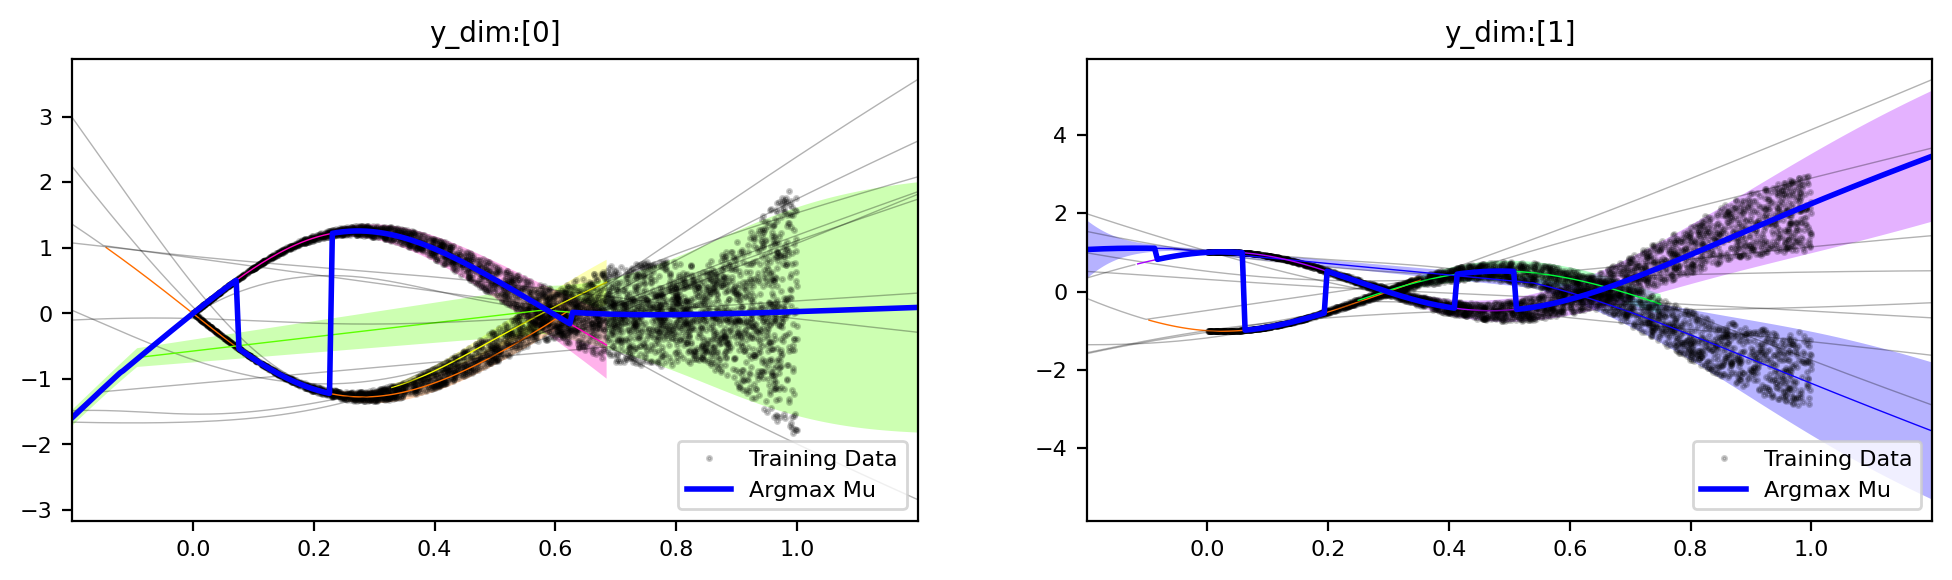

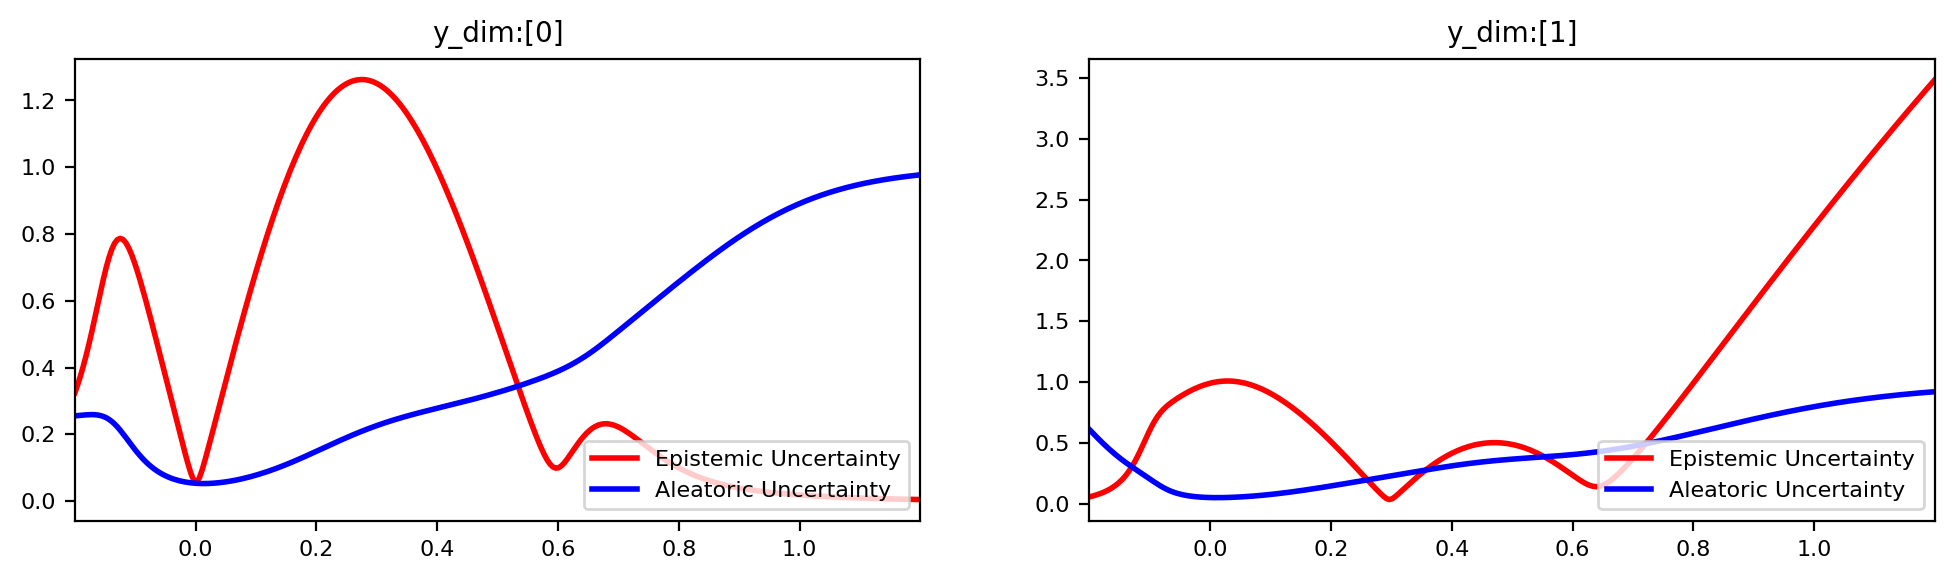

[16000/20000] loss:[-0.759]
[17000/20000] loss:[-0.978]
[18000/20000] loss:[-0.315]
[19000/20000] loss:[-1.097]
[19999/20000] loss:[-0.548]


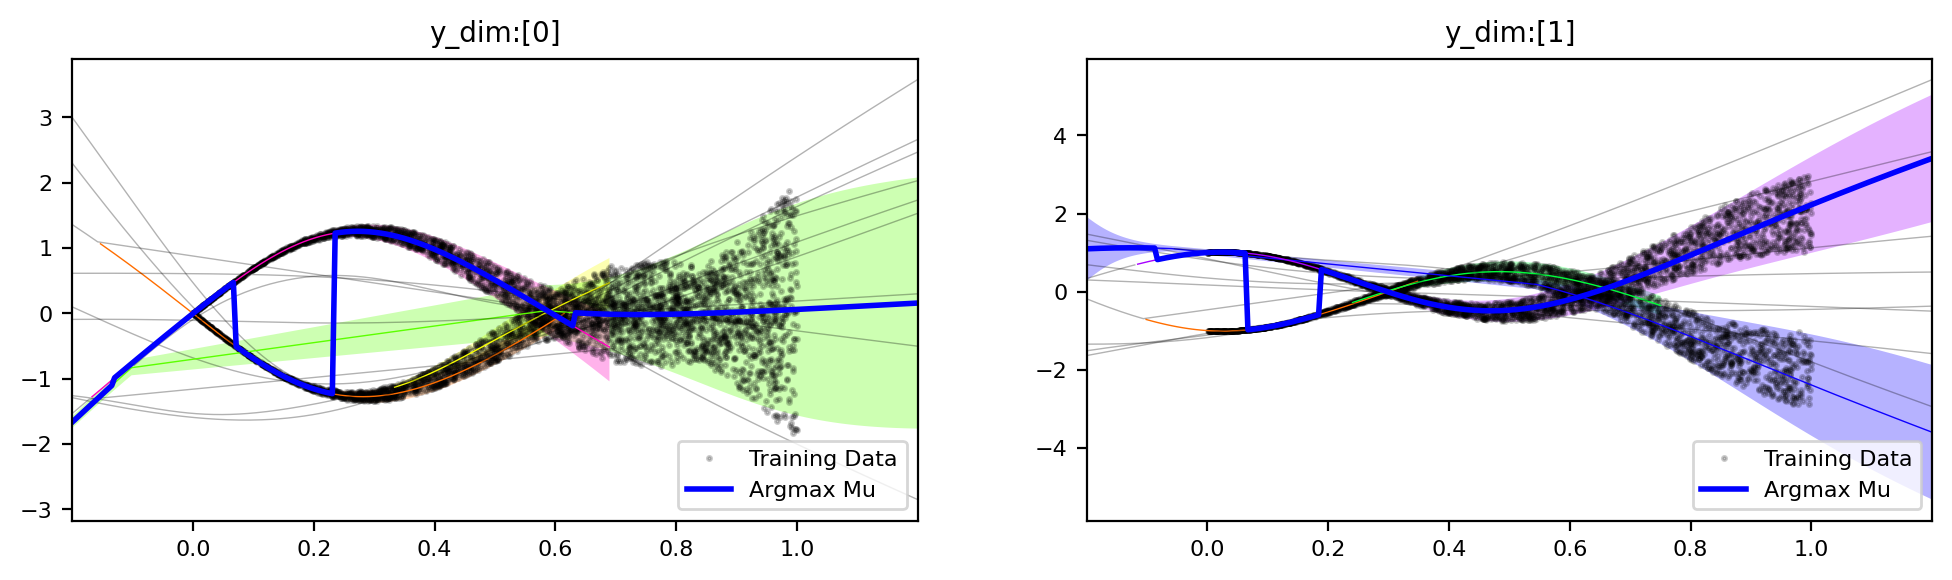

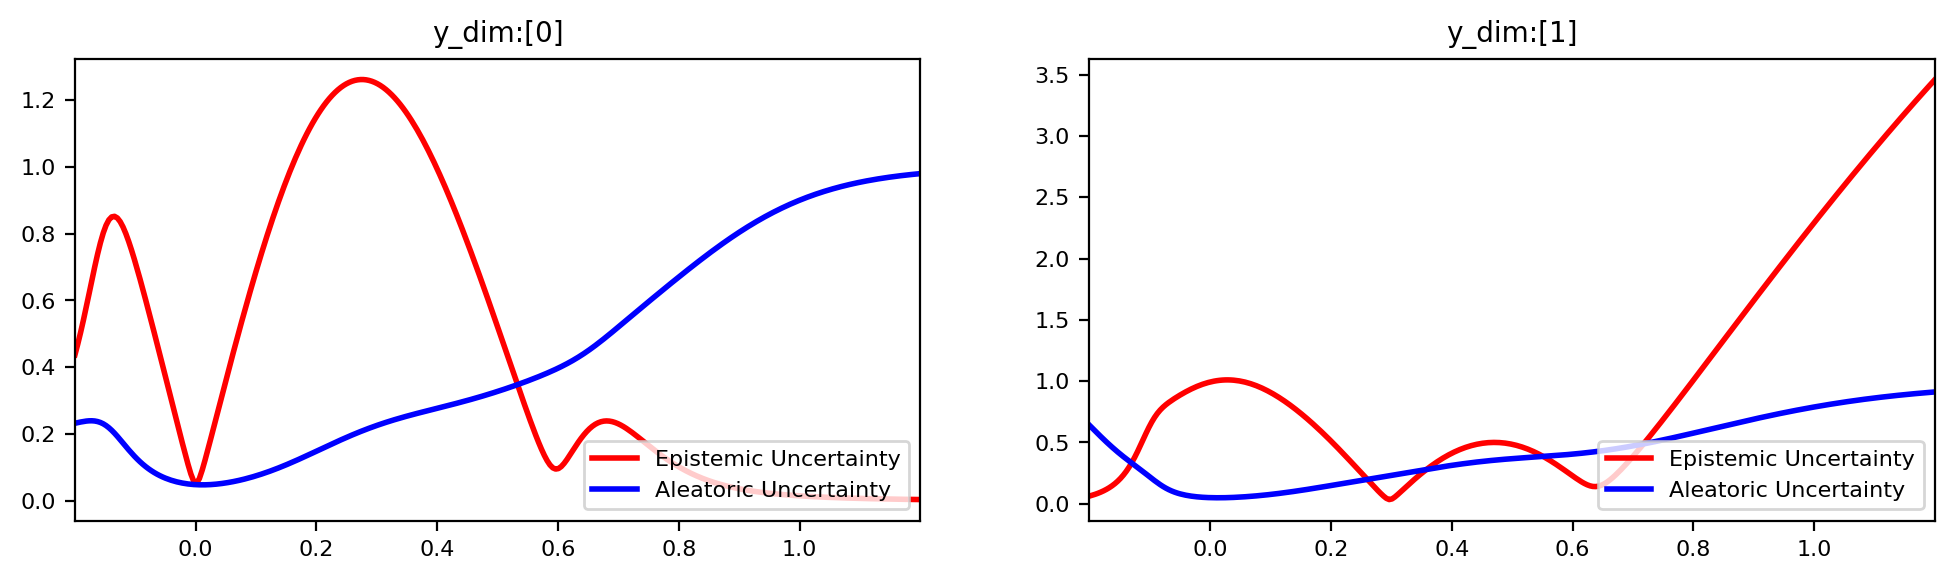

Done.


In [6]:
print ("Start training")
np.random.seed(seed=0)
th.manual_seed(seed=0)
mdn.init_param()
mdn.train()
x_train = th.Tensor(x_train_np).to(device)
y_train = th.Tensor(y_train_np).to(device)

for it in range(int(max_iter)):
    batch_idx = np.random.permutation(n_train)[:batch_size]
    x_batch,y_batch = x_train[batch_idx],y_train[batch_idx]

    # Update
    mdn.zero_grad()
    pi_batch,mu_batch,sigma_batch = mdn.forward(x_batch)
    gmm_out = gmm_forward(pi_batch,mu_batch,sigma_batch,y_batch)
    loss = th.mean(gmm_out['nlls']) + 0.1*F.mse_loss(y_batch,gmm_out['argmax_mu'])
    loss.backward()
    optm.step()
    schd.step()
    
    # Print
    if ((it%print_every)==0) or (it==(max_iter-1)):
        print ("[%4d/%d] loss:[%.3f]"%(it,max_iter,loss))

    # Plot
    if ((it%plot_every)==0) or (it==(max_iter-1)):
        eval_mdn_1d(mdn,x_train_np,y_train_np,figsize=(12,3),device=device)

print ("Done.")